In [2]:
import sys
sys.path += ['..']

In [3]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from financial_ml.features.systematic_default import FirmStructuralCreditRisk

In [3]:
fmp_api_key = ''

In [4]:
ticker = 'AAPL'
api_base = 'https://financialmodelingprep.com/api'
balance_sheet_api = f'{api_base}/v3/balance-sheet-statement/{ticker}?period=quarter&limit=120&apikey={fmp_api_key}'

In [5]:
balance_sheets = requests.get(balance_sheet_api).json()

In [6]:
balance_sheets_df = pd.DataFrame(balance_sheets)
balance_sheets_df = balance_sheets_df[['acceptedDate', 'shortTermDebt', 'longTermDebt']]
balance_sheets_df['acceptedDate'] = pd.to_datetime(balance_sheets_df['acceptedDate'])
balance_sheets_df = balance_sheets_df.sort_values('acceptedDate')
balance_sheets_df

,acceptedDate,shortTermDebt,longTermDebt
119,1993-06-30 00:00:00,308200000,0
118,1993-09-30 00:00:00,823200000,0
117,1994-01-26 00:00:00,752257000,0
116,1994-03-31 00:00:00,490700000,304900000
115,1994-08-12 00:00:00,515608000,304815000
...,...,...,...
4,2022-04-28 18:03:58,16658000000,103323000000
3,2022-07-28 18:06:56,24991000000,94700000000
2,2022-10-27 18:01:14,21110000000,98959000000
1,2023-02-02 18:01:30,11483000000,99627000000


In [7]:
market_cap_api = f'{api_base}/v3/historical-market-capitalization/{ticker}?limit=7700&apikey={fmp_api_key}'

In [8]:
market_caps = requests.get(market_cap_api).json()

In [9]:
market_caps = pd.DataFrame(market_caps)
market_caps = market_caps[['date', 'marketCap']]
market_caps['date'] = pd.to_datetime(market_caps['date'])
market_caps = market_caps.sort_values('date').reset_index(drop=True)
market_caps

,date,marketCap
0,1992-12-01,7057333123
1,1992-12-02,6936184876
2,1992-12-03,6966471938
3,1992-12-04,6890754284
4,1992-12-07,6996759000
...,...,...
7695,2023-06-23,2947145908720
7696,2023-06-26,2924886021580
7697,2023-06-27,2968932181240
7698,2023-06-28,2987718894500


In [10]:
join_indices = market_caps['date'].apply(lambda d: balance_sheets_df['acceptedDate'].searchsorted(d) - 1).values
balance_sheets_join = balance_sheets_df.iloc[join_indices].copy()
balance_sheets_join['acceptedDate'] = balance_sheets_join['acceptedDate'].where(join_indices >= 0)
balance_sheets_join = balance_sheets_join.reset_index(drop=True)
balance_sheets_join

,acceptedDate,shortTermDebt,longTermDebt
0,NaT,12574000000,97041000000
1,NaT,12574000000,97041000000
2,NaT,12574000000,97041000000
3,NaT,12574000000,97041000000
4,NaT,12574000000,97041000000
...,...,...,...
7695,2023-05-04 18:03:52,12574000000,97041000000
7696,2023-05-04 18:03:52,12574000000,97041000000
7697,2023-05-04 18:03:52,12574000000,97041000000
7698,2023-05-04 18:03:52,12574000000,97041000000


In [12]:
treasury_yields = pd.read_csv('../data/treasury_yield_1Y.csv')
treasury_yields['DATE'] = pd.to_datetime(treasury_yields['DATE'])
treasury_yields = treasury_yields.dropna(subset='DGS1')
treasury_yields = treasury_yields[treasury_yields['DGS1'] != '.']
treasury_yields['DGS1'] = treasury_yields['DGS1'].astype(float)/100

In [13]:
treasury_yields

,DATE,DGS1
0,1993-01-04,0.0356
1,1993-01-05,0.0358
2,1993-01-06,0.0362
3,1993-01-07,0.0370
4,1993-01-08,0.0356
...,...,...
7944,2023-06-16,0.0524
7946,2023-06-20,0.0524
7947,2023-06-21,0.0525
7948,2023-06-22,0.0529


In [20]:
bnd_idx = pd.read_excel('../data/sp500_bnd_idx.xls').dropna()
bnd_idx = bnd_idx.iloc[2:]
bnd_idx.columns = ['date', 'price']
bnd_idx['date'] = pd.to_datetime(bnd_idx['date'])
bnd_idx['price'] = bnd_idx['price'].astype(float)

In [25]:
bnd_idx

,date,price
6,2013-05-31,368.08
7,2013-06-03,368.35
8,2013-06-04,367.69
9,2013-06-05,367.42
10,2013-06-06,367.75
...,...,...
2543,2023-06-22,469.57
2544,2023-06-23,470.95
2545,2023-06-26,471.64
2546,2023-06-27,470.89


In [26]:
spy_yf = yf.Ticker('SPY')
spy_df = spy_yf.history(interval='1d', period='11y', prepost=False)

In [27]:
spy_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-07-02 00:00:00-04:00,111.117284,111.255691,110.335693,111.141708,129524500,0.0,0.0,0.0
2012-07-03 00:00:00-04:00,111.117248,111.955837,111.003265,111.874428,80450000,0.0,0.0,0.0
2012-07-05 00:00:00-04:00,111.459241,112.191997,110.962600,111.369682,126177500,0.0,0.0,0.0
2012-07-06 00:00:00-04:00,110.294962,110.539214,109.790184,110.311249,151192100,0.0,0.0,0.0
2012-07-09 00:00:00-04:00,110.221715,110.376408,109.668076,110.172867,103780500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-06-23 00:00:00-04:00,432.929993,435.059998,432.470001,433.209991,92028700,0.0,0.0,0.0
2023-06-26 00:00:00-04:00,432.619995,434.609985,431.190002,431.440002,72823600,0.0,0.0,0.0
2023-06-27 00:00:00-04:00,432.350006,436.809998,431.880005,436.170013,72813700,0.0,0.0,0.0


In [52]:
mkt_idx = pd.DataFrame({'date': pd.to_datetime(spy_df.index.date), 'price': spy_df['Close']}).reset_index(drop=True)
mkt_idx

,date,price
0,2012-07-02,111.141708
1,2012-07-03,111.874428
2,2012-07-05,111.369682
3,2012-07-06,110.311249
4,2012-07-09,110.172867
...,...,...
2761,2023-06-23,433.209991
2762,2023-06-26,431.440002
2763,2023-06-27,436.170013
2764,2023-06-28,436.390015


In [ ]:
dataset = pd.concat([market_caps, balance_sheets_join], axis=1)
dataset = dataset.dropna(subset='acceptedDate')
dataset = dataset.merge(treasury_yields, left_on='date', right_on=['DATE']).rename(columns={'DGS1': 'treasury_yield'})
dataset = dataset.merge(bnd_idx, on='date').rename(columns={'price': 'bnd_price'})
dataset = dataset.merge(mkt_idx, on='date').rename(columns={'price': 'mkt_price'})
dataset = dataset.drop(columns=['DATE', 'acceptedDate'])
dataset = dataset.dropna(subset='treasury_yield')
dataset.to_csv('../data/aapl_structural_data.csv', index=False)

In [4]:
dataset = pd.read_csv('../data/aapl_structural_data.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

In [5]:
dataset

,date,marketCap,shortTermDebt,longTermDebt,treasury_yield,bnd_price,mkt_price
0,2013-05-31,413135584848,0,0,0.0014,368.08,135.333771
1,2013-06-03,414038402618,0,0,0.0014,368.35,136.078995
2,2013-06-04,412744621027,0,0,0.0014,367.69,135.424896
3,2013-06-05,408886425427,0,0,0.0014,367.42,133.528793
4,2013-06-06,402777615727,0,0,0.0014,367.75,134.737625
...,...,...,...,...,...,...,...
2510,2023-06-16,2919360517680,12574000000,97041000000,0.0524,470.06,439.459991
2511,2023-06-20,2920781361540,12574000000,97041000000,0.0524,471.45,437.179993
2512,2023-06-21,2904204849840,12574000000,97041000000,0.0525,471.74,434.940002
2513,2023-06-22,2952197798000,12574000000,97041000000,0.0529,469.57,436.510010


In [6]:
dataset_monthly = dataset.resample('MS', on='date').first()

In [7]:
dataset_monthly

,marketCap,shortTermDebt,longTermDebt,treasury_yield,bnd_price,mkt_price
date,,,,,,
2013-05-01,413135584848,0,0,0.0014,368.08,135.333771
2013-06-01,414038402618,0,0,0.0014,368.35,136.078995
2013-07-01,378663951820,0,0,0.0015,359.17,134.310226
2013-08-01,422577570153,0,16958000000,0.0013,359.46,142.051208
2013-09-01,452098590112,0,16958000000,0.0014,357.83,136.832336
...,...,...,...,...,...,...
2023-02-01,2295925806220,21110000000,98959000000,0.0466,477.31,407.723602
2023-03-01,2294031347740,11483000000,99627000000,0.0506,457.82,391.783875
2023-04-01,2623351380180,11483000000,99627000000,0.0460,474.30,409.429138


In [8]:
equity_ratio = 0.81
equity_mkt_rets = np.diff(np.log(dataset_monthly['mkt_price']))
bnd_mkt_rets = np.diff(np.log(dataset_monthly['bnd_price']))
market_rets = equity_ratio * equity_mkt_rets + (1 - equity_ratio) * bnd_mkt_rets
debt_values = (dataset_monthly['shortTermDebt'] + dataset_monthly['longTermDebt'] / 2).values
risk_free_rates = dataset_monthly['treasury_yield'].iloc[:-1].values

model = FirmStructuralCreditRisk()
res = model.fit(
    market_rets=market_rets,
    equity_values=dataset_monthly['marketCap'].values,
    debt_values=debt_values,
    debt_maturities=[1] * len(dataset_monthly),
    interval=1/12,
    risk_free_rates=risk_free_rates,
)

<Axes: ylabel='marketCap'>

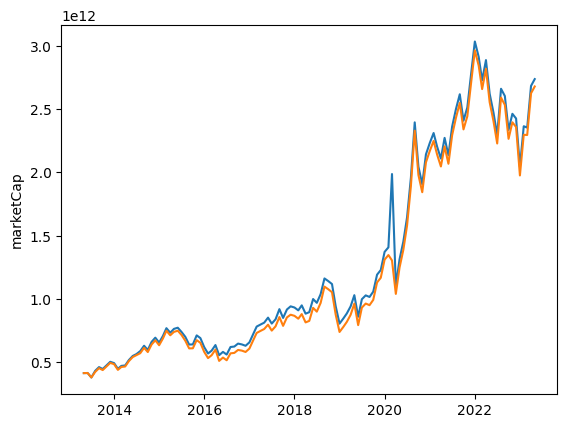

In [9]:
sns.lineplot(x=dataset_monthly.index.values[:-1], y=res[1])
sns.lineplot(x=dataset_monthly.index.values[:-1], y=dataset_monthly['marketCap'].iloc[:-1])

In [10]:
equity_mk_ex_rets = equity_mkt_rets - risk_free_rates/12
mkt_ex_rets = market_rets - risk_free_rates*1/12

equity_ex_rets = np.diff(np.log(dataset_monthly['marketCap'].values)) - risk_free_rates*1/12
asset_ex_rets = res[0] - risk_free_rates*1/12

<Axes: >

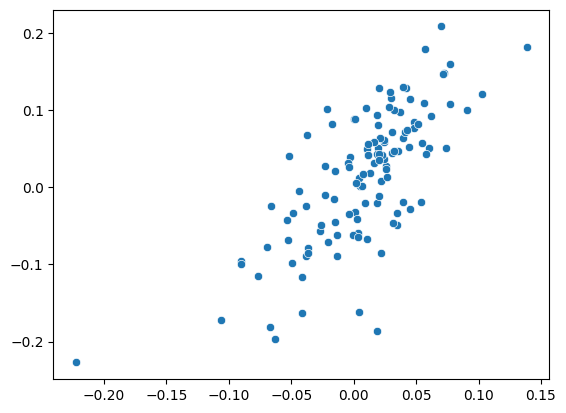

In [11]:
sns.scatterplot(x=equity_mk_ex_rets, y=equity_ex_rets)

<Axes: >

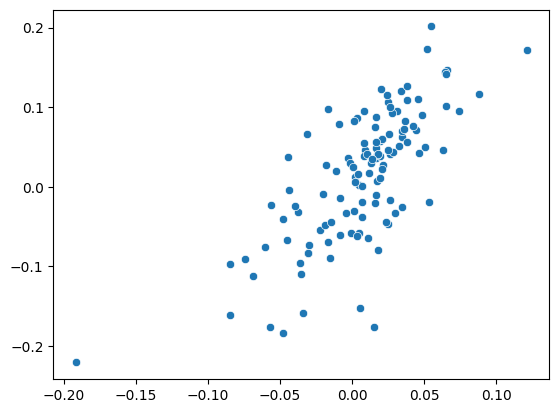

In [12]:
sns.scatterplot(x=mkt_ex_rets, y=asset_ex_rets)

In [13]:
model.firm_params

FirmParams(alpha=0.061542118810687996, beta=1.5084694102104117, sigma=0.1940891405107459)

In [14]:
model.predict_default(
    equity_value=dataset_monthly['marketCap'].iloc[-1],
    debt_value=debt_values[-1],
    debt_maturity=1,
    risk_free_rate=risk_free_rates[-1],
    market_ret=0.12
)

0.0